In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls -1 /content/drive/MyDrive/Colab\ Notebooks/Plant/train_images/ | wc -l

18632


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import cv2
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense

from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
# from keras.models import Sequential
# from keras.layers import Dense
from sklearn.metrics import accuracy_score
from time import time

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping



In [ ]:
# load dataset

# sur colab
# TRAIN_IMAGES_PATH = "F:/Projet_computer_vision/plant-pathology-2021-fgvc8/train_images/"

# en local
TRAIN_IMAGES_PATH = "drive/MyDrive/Colab Notebooks/Plant/train_images/"
TEST_IMAGES_PATH = "drive/MyDrive/Colab Notebooks/Plant/test_images/"

# sur colab
TRAIN_PATH = "drive/MyDrive/Colab Notebooks/Plant/train_comp.csv"
SUB_PATH = "drive/MyDrive/Colab Notebooks/Plant/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
# test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)
# print(train_data[:5])
test_data = pd.read_csv(SUB_PATH)
# print(test_data)

# bon 3
classes=set()
for v in train_data["labels"].values:
    classes.update(set(v.split()))
print("classes= ", classes)

#On peut associer les images des feuilles à 5 classes possibles:
#'complex', 'frog_eye_leaf_spot', 'powdery_mildew', 'rust', 'scab'
# healthy , quand aucune de ces classes n'est là.

# train_data['healthy']=train_data['labels'].apply(lambda x: 1 if 'healthy' in x else 0) 
train_data['scab']=train_data['labels'].apply(lambda x: 1 if 'scab' in x else 0) 
train_data['rust']=train_data['labels'].apply(lambda x: 1 if 'rust' in x else 0) 
train_data['powdery_mildew']=train_data['labels'].apply(lambda x: 1 if 'powdery_mildew' in x else 0) 
train_data['frog_eye_leaf_spot']=train_data['labels'].apply(lambda x: 1 if 'frog_eye_leaf_spot' in x else 0) 
train_data['complex']=train_data['labels'].apply(lambda x: 1 if 'complex' in x else 0) 
train_data
print(train_data[:3])

# en local 
def add_path_compressed_train(file):
    return TRAIN_IMAGES_PATH  + file

def add_path_test(file):
    return TEST_IMAGES_PATH + file


train_files= train_data.image.map(add_path_compressed_train).values
print(train_files[:3])

test_files= test_data.image.map(add_path_test).values
print(test_files)

labels = np.float32(train_data.loc[:, 'scab':'complex'].values)
print("labels= ", labels[:3])

print("shapes= ", train_files.shape, labels.shape,)

classes=  {'healthy', 'complex', 'rust', 'scab', 'powdery_mildew', 'frog_eye_leaf_spot'}
                             image  ... complex
0  Compressed_800113bb65efe69e.jpg  ...       0
1  Compressed_8002cb321f8bfcdf.jpg  ...       1
2  Compressed_80070f7fb5e2ccaa.jpg  ...       0

[3 rows x 7 columns]
['drive/MyDrive/Colab Notebooks/Plant/train_images/Compressed_800113bb65efe69e.jpg'
 'drive/MyDrive/Colab Notebooks/Plant/train_images/Compressed_8002cb321f8bfcdf.jpg'
 'drive/MyDrive/Colab Notebooks/Plant/train_images/Compressed_80070f7fb5e2ccaa.jpg']
['drive/MyDrive/Colab Notebooks/Plant/test_images/85f8cb619c66b863.jpg'
 'drive/MyDrive/Colab Notebooks/Plant/test_images/ad8770db05586b59.jpg'
 'drive/MyDrive/Colab Notebooks/Plant/test_images/c7b03e718489f3ca.jpg']
labels=  [[0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0.]]
shapes=  (18632,) (18632, 5)


In [ ]:
def decode_image(filename,label=None,  image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label
    
def make_dataset(train_images, train_labels, valid_images, valid_labels, test_files, image_size,batch_size):
    
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((train_images, train_labels))   
        #.from_tensor_slices((train_images[:10], train_labels[:10]))   
        .map(tf.autograph.experimental.do_not_convert(lambda x,y: decode_image(x,y, image_size)), num_parallel_calls=AUTO )           
        #.map(decode_image, num_parallel_calls=AUTO)
        .map(data_augment, num_parallel_calls=AUTO)
        .repeat()
        .shuffle(512)
        .batch(batch_size)
        .prefetch(AUTO)
    )
    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((valid_images, valid_labels))
        # .from_tensor_slices((valid_images[:2], valid_labels[:2]))
        # .map(decode_image, num_parallel_calls=AUTO)
        .map(tf.autograph.experimental.do_not_convert(lambda x,y: decode_image(x,y, image_size)), num_parallel_calls=AUTO )           
        .batch(batch_size)
        .cache()
        .prefetch(AUTO)
    )
    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(test_files)
        .map(tf.autograph.experimental.do_not_convert(lambda x: decode_image(x,None, image_size)), num_parallel_calls=AUTO )           
        .batch(batch_size)
    )
    return train_dataset,valid_dataset,test_dataset


        

def get_model(image_shape):
    # MobileNetV2
    #Adding the final layers to the above base models where the actual classification is done in the dense layers
    mobilenetV2= MobileNetV2(include_top=False, weights="imagenet", \
        input_tensor=None, input_shape=image_shape, pooling='avg') 
    model_MobileNetV2 = Sequential()
    model_MobileNetV2.add(mobilenetV2)
    model_MobileNetV2.add(Dense(5, activation=('sigmoid')))

    model_MobileNetV2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    model_MobileNetV2.summary()
    return model_MobileNetV2


def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    # lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn   


def train(model, train_dataset, valid_dataset,epochs, len_train,  batch_size, filenum):
         
    
    # learning rate
    lrfn = build_lrfn()
    STEPS_PER_EPOCH = len_train // batch_size
    # STEPS_PER_EPOCH = 10
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    
    # Early Stopping
    early_stop= EarlyStopping(monitor='val_accuracy',patience=5, mode='max' )
    
    # save the weights given the best val_loss
    filepath='drive/MyDrive/Colab Notebooks/Plant/MobileNetV2-best-dataset-062021-'+str(filenum)+'.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    # callbacks_list = [lr_schedule,checkpoint ]
    callbacks_list = [lr_schedule,early_stop, checkpoint ]
    
    Network=model.fit(train_dataset, steps_per_epoch=STEPS_PER_EPOCH, verbose=1, \
                            validation_data=valid_dataset,callbacks=callbacks_list,epochs=epochs)
    
    return Network
    
    
def validate(model, valid_dataset,len_valid,n):    # exactement : accuracy_score(valid_true_labels, np.round(valid_pred)) de sklearn
   
    # batch_size= 16
    # transforme le dataset des labels de validation en numpy ndarray 
    def pre_validation(valid_dataset):

        valid_true_labels=np.zeros((len_valid,5))

        for i, x in enumerate(valid_dataset):           
                for  j in range(16):
                    if j + 16 * i  < len_valid:                       
                        valid_true_labels[j+ 16 * i]= x[1][j]            
                     # print(i)
                    else:
                        break;               

        return valid_true_labels
    
    valid_true_labels=  pre_validation(valid_dataset)
    
    model = load_model("drive/MyDrive/Colab Notebooks/Plant/MobileNetV2-best-dataset-062021-"+str(n)+".hdf5")
    valid_pred = model.predict(valid_dataset)
    
    # c'est exactement : accuracy_score(valid_true_labels, np.round(valid_pred)) (from sklearn.metrics import accuracy_score)
    accuracy= np.mean(np.all(valid_true_labels == np.round(valid_pred), axis=1))
    
    return accuracy

# une autre manière pour calculer la validation accuracy qui donne le même résultat.
def validate1(model, valid_dataset,len_valid,n): 
   
    def pre_validation(valid_dataset):

        valid_true_labels=np.zeros((len_valid,5))

        for i, x in enumerate(valid_dataset):           
                for  j in range(16):
                    if j + 16 * i  < len_valid:
                        
                        valid_true_labels[j+ 16 * i]= x[1][j]            
                    
                    else:
                        break;               

        return valid_true_labels
    
    valid_true_labels=  pre_validation(valid_dataset)
    
    
    valid_pred = model.predict(valid_dataset)
    accuracy_score(valid_true_labels, np.round(valid_pred))
    
    return accuracy

# fonction qui trace les 2 courbes loss et validation loss ainsi que l'accuracy et la validation accuracy
def loss_accuracy_curves(Network) :
    plt.subplot(121)
    plt.plot(Network.history['loss'],label='Train')
    plt.plot(Network.history['val_loss'],label='Validation')
    plt.ylabel('Loss',fontsize=20)
    plt.xlabel('epoch')
    plt.legend(['Training', 'Validation'], loc='best')  # upper

    plt.subplot(122)
    plt.plot(Network.history['accuracy'],label='Train')
    plt.plot(Network.history['val_accuracy'],label='Validation')
    plt.ylabel('Accuracy',fontsize=20)
    plt.xlabel('epoch')
    plt.legend(['Training', 'Validation'], loc='best')  # upper
    plt.tight_layout()

    plt.show()
    
    

Split des données entre train set et validation set en utlisant la 3-fold cross validation 
(12421,) (12421, 5)
(6211,) (6211, 5)
12421 6211

Création des datasets train, validation et test

Création du modèle à partir d'une Keras application (deep learning pre-trained models
https://keras.io/api/applications/ 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________

training
Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
776/776 [==============================] - 1730s 2s/step - loss: 0.4499 - accuracy: 0.4367 - val_l

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
776/776 [==============================] - 1319s 2s/step - loss: 0.3316 - accuracy: 0.6117 - val_loss: 0.3455 - val_accuracy: 0.5811

Epoch 00002: val_accuracy improved from 0.35985 to 0.58107, saving model to drive/MyDrive/Colab Notebooks/Plant/MobileNetV2-best-dataset-062021-1.hdf5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
776/776 [==============================] - 1334s 2s/step - loss: 0.2784 - accuracy: 0.6712 - val_loss: 0.2872 - val_accuracy: 0.6393

Epoch 00003: val_accuracy improved from 0.58107 to 0.63935, saving model to drive/MyDrive/Colab Notebooks/Plant/MobileNetV2-best-dataset-062021-1.hdf5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
776/776 [==============================] - 1336s 2s/step - loss: 0.2450 - accuracy: 0.7102 - val_loss: 0.2461 - val_accuracy: 0.7195

Epoch

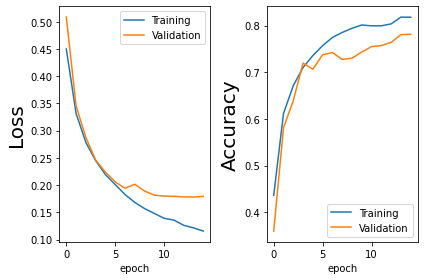

>>>>>>>>>>>>>>>>>>>>>>>>>>> validation_accuracy 0.756
filenum=  1
durée du training avec 3-fold cross-validation  (en secondes) = 20532.294749498367
Validation Accuracy: moyenne 0.756 ecart-type(0.000)


In [ ]:
image_size=(100, 100)
AUTO = tf.data.experimental.AUTOTUNE
batch_size =16

X = train_files   # fichiers des images des feuilles (18 632)
y = labels     # dataframes des 5 colonnes (1 ou 0) des pathologies
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=1)

debut= time()

def evaluate_model_plant_patho(X,y):
    n=1
    list_val_accuracy=[]
    for train_ix, test_ix in cv.split(X):
        
        print("Split des données entre train set et validation set en utlisant la 3-fold cross validation ")
        train_images, valid_images = X[train_ix], X[test_ix]
        train_labels, valid_labels = y[train_ix], y[test_ix]
        
        print(train_images.shape,  train_labels.shape)  # 12 421 ou 12 422
        print(valid_images.shape, valid_labels.shape) # len_valid= len(train_data) // 3  (6 210)  
                                                    # ou len_valid= len(train_data) // 3 + 1  (6 211)

        
        len_train = train_images.shape[0] 
        len_valid=valid_images.shape[0]
        
        print(len_train, len_valid)
        
        print("\nCréation des datasets train, validation et test")
        train_dataset,valid_dataset,test_dataset= make_dataset(train_images, train_labels, valid_images, valid_labels, test_files,\
                                                               image_size, batch_size)
        
        
        
        print("\nCréation du modèle à partir d'une Keras application (deep learning pre-trained models")
        print("https://keras.io/api/applications/ ")
        
        image_shape = image_size + (3,) 
        model= get_model(image_shape)
        
        print("\ntraining")
        # training du modèle et sauvegarde du meilleur modèle (max val_accuracy) rencontré lors des epochs (sauvegarde des poids)
        Network = train(model, train_dataset, valid_dataset,epochs=15, len_train=len_train, batch_size=16, filenum=n)
         
                 
        
        # faire une prediction du validation set à partir du modèle et la comparer aux vrais labels
        # ça équivaut à un accuracy_score de sklearn.
        # attention : c'est pas équivalent au model.evaluate(valid_dataset) de keras, ça ne donne pas les mêmes résultats car 
        # il s'agit d'une classification Multi-Class et multi-label.
        
        print("\nvalidation")
        val_accuracy = validate(model, valid_dataset,len_valid,n)
        
        
        # courbes de loss / validation loss et courbe d'accuracy / validation accuracy
        loss_accuracy_curves(Network)   
        
        # Sauvegarde de la val_accuracy dans uen liste pour un calcul de moyenne et d'écart-type
        print('>>>>>>>>>>>>>>>>>>>>>>>>>>> validation_accuracy %.3f' % val_accuracy)
        list_val_accuracy.append(val_accuracy)
        
        print("filenum= ",n)
        n +=1 
        
        
        break;
    return list_val_accuracy




list_val_accuracy= evaluate_model_plant_patho(X,y)
duree_totale = time()- debut
print("durée du training avec 3-fold cross-validation  (en secondes) =", duree_totale)
print('Validation Accuracy: moyenne %.3f ecart-type(%.3f)' % (mean(list_val_accuracy), std(list_val_accuracy)))   


In [ ]:
image_size=(100, 100)
AUTO = tf.data.experimental.AUTOTUNE
batch_size =16
test_dataset = (
              tf.data.Dataset
              .from_tensor_slices(test_files)
              .map(tf.autograph.experimental.do_not_convert(lambda x: decode_image(x,None, image_size)), num_parallel_calls=AUTO )           
              .batch(batch_size)
                        )

In [ ]:
model = load_model("drive/MyDrive/Colab Notebooks/Plant/MobileNetV2-best-dataset-062021-1.hdf5")
Test_pred =model.predict(test_dataset)  
print(Test_pred.shape) 
print(Test_pred)

(3, 5)
[[2.3377746e-02 1.7738640e-03 1.0923071e-04 1.5613437e-04 1.0336936e-03]
 [1.9125855e-01 4.1015148e-03 8.5098147e-03 1.7083874e-01 8.2656187e-01]
 [5.4879433e-01 5.6467950e-03 4.6065450e-04 8.6367524e-01 1.7655683e-01]]


In [ ]:
Test_pred_round=Test_pred.round()
Test_pred_round

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
df_test=pd.DataFrame(Test_pred_round, columns=['scab','rust','powdery_mildew','frog_eye_leaf_spot','complex'])
df_test

,scab,rust,powdery_mildew,frog_eye_leaf_spot,complex
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0


In [ ]:
# df_test['labels']='healthy'
df_test['labels'] = df_test['scab'].apply(lambda x:'scab ' if x==1 else "") \
                        +  df_test['rust'].apply(lambda x:'rust ' if x==1 else "")  \
                        +   df_test['powdery_mildew'].apply(lambda x:'powdery_mildew ' if x==1 else "")  \
                        + df_test['frog_eye_leaf_spot'].apply(lambda x:'frog_eye_leaf_spot ' if x==1 else "") \
                        + df_test['complex'].apply(lambda x:'complex ' if x==1 else "") 
                                                                                
df_test['labels']= df_test['labels'].str.strip()
df_test['labels'] = df_test['labels'].apply(lambda x:'healthy' if x=="" else x)
test_labels= df_test['labels']
print(test_labels)

0                    healthy
1                    complex
2    scab frog_eye_leaf_spot
Name: labels, dtype: object
